# <details> <summary><strong>🧠 Contrastive Learning Summary (Click to Expand)</strong></summary>
🔍 Contrastive Learning Overview
Contrastive Learning is a self-supervised learning method where the model learns to pull similar samples closer and push dissimilar ones apart in embedding space. It's widely used in NLP, Computer Vision, Multimodal AI, and Retrieval Systems.

🧾 Why It's Useful:
Helps models learn rich, generalizable embeddings without requiring labeled data.

Ideal for semantic similarity, search, recommendation, clustering, and retrieval tasks.

Backbone for popular models like SimCLR, CLIP, SBERT, etc.

### 🔍 Overview of Contrastive Loss Functions

| **Loss Function**       | **Uses Positive?** | **Uses Multiple Negatives?** | **Requires Label?** | **Common Application**            |
|-------------------------|--------------------|-------------------------------|----------------------|-----------------------------------|
| **Contrastive Loss**    | ✔️                 | ❌                             | ✔️                   | Basic similarity learning         |
| **Triplet Loss**        | ✔️                 | ✔️ (one)                      | ✔️                   | Ranking, face recognition         |
| **Lifted Structured**   | ✔️                 | ✔️ (all in batch)             | ✔️                   | Efficient metric learning         |
| **N-pair Loss**         | ✔️                 | ✔️                            | ✔️                   | Multi-class classification        |
| **NCE (Noise Contrastive Estimation)** | ✔️ | ✔️                            | ❌                   | Word embeddings                   |
| **InfoNCE**             | ✔️                 | ✔️                            | ❌                   | Self-supervised learning          |
| **SNNL (Soft Nearest Neighbors Loss)** | ✔️ | ✔️                            | ✔️                   | Representation clustering         |

---

### 💡 Key Points

- ✅ Some loss functions like **NCE** and **InfoNCE** work well without labels, making them ideal for **self-supervised** or **unsupervised** learning setups.
- 📌 Losses like **Triplet** and **Contrastive** require explicit labels and are typically used in **supervised metric learning**.
- 🔄 **Lifted Structured**, **N-pair**, and **SNNL** allow learning richer relationships by using **multiple negatives**, improving performance for tasks like **face recognition, document retrieval**, and **clustering**.
- 🧠 These losses are foundational in training **embedding models**, which are later used for tasks like **semantic search, recommendation engines, visual similarity**, and **multimodal retrieval**.

---

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# ===== 1. Contrastive Loss =====

In [15]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss: Basic similarity learning loss that pulls similar pairs together
    and pushes dissimilar pairs apart.

    Uses positive examples: Yes - direct pairs are pulled together
    Uses multiple negatives: No - works on pairs only
    Requires label: Yes - needs similarity labels (0 or 1)
    Application: Basic similarity learning
    """
    def __init__(self, margin=1.0):
        """
        Args:
            margin: Margin to enforce for negative pairs
        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, x1, x2, y):
        """
        Args:
            x1: First embedding tensor of shape (batch_size, embed_dim)
            x2: Second embedding tensor of shape (batch_size, embed_dim)
            y: Binary labels: 1 for similar pairs, 0 for dissimilar pairs
        """
        # Calculate euclidean distance
        dist = F.pairwise_distance(x1, x2)

        # Contrastive loss formula
        # For similar pairs (y=1): loss = distance^2
        # For dissimilar pairs (y=0): loss = max(0, margin - distance)^2
        loss_similar = y * torch.pow(dist, 2)
        loss_dissimilar = (1 - y) * torch.pow(torch.clamp(self.margin - dist, min=0.0), 2)

        loss = torch.mean(loss_similar + loss_dissimilar) / 2.0
        return loss

# ===== 2. Triplet Loss =====

In [16]:
class TripletLoss(nn.Module):
    """
    Triplet Loss: Uses triplets of (anchor, positive, negative) and ensures
    the positive is closer to the anchor than the negative.

    Uses positive examples: Yes - positive samples are pulled toward anchor
    Uses multiple negatives: Yes - one negative per triplet
    Requires label: Yes - to form triplets
    Application: Ranking, face recognition
    """
    def __init__(self, margin=1.0):
        """
        Args:
            margin: Margin to enforce between positive and negative distances
        """
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        Args:
            anchor: Anchor embeddings of shape (batch_size, embed_dim)
            positive: Positive embeddings of shape (batch_size, embed_dim)
            negative: Negative embeddings of shape (batch_size, embed_dim)
        """
        # Calculate distances
        distance_positive = F.pairwise_distance(anchor, positive)
        distance_negative = F.pairwise_distance(anchor, negative)

        # Triplet loss formula: max(0, d(a,p) - d(a,n) + margin)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return torch.mean(losses)


# ===== 3. Lifted Structured Loss =====

In [17]:
class LiftedStructuredLoss(nn.Module):
    """
    Lifted Structured Loss: Considers all positive and negative pairs in the batch
    to create a more efficient metric learning framework.

    Uses positive examples: Yes - all positives are pulled together
    Uses multiple negatives: Yes - all negatives in batch
    Requires label: Yes - needs class labels
    Application: Efficient metric learning
    """
    def __init__(self, margin=1.0):
        """
        Args:
            margin: Margin for the loss
        """
        super(LiftedStructuredLoss, self).__init__()
        self.margin = margin

    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: Feature embeddings of shape (batch_size, embed_dim)
            labels: Class labels of shape (batch_size)
        """
        # Compute pairwise distances
        pairwise_dist = torch.cdist(embeddings, embeddings)

        # Create mask for positive pairs (same label)
        labels = labels.view(-1, 1)
        pos_mask = (labels == labels.t()).float()
        pos_mask.fill_diagonal_(0)  # Remove self-comparisons
        neg_mask = 1 - pos_mask

        # Get all positive pairs
        pos_pairs = pairwise_dist * pos_mask

        # For each positive pair (i,j), compute max term: log(sum(exp(margin - D_ik))) + log(sum(exp(margin - D_jl)))
        # where k,l are negative samples for i,j respectively
        n = embeddings.size(0)
        loss = 0.0

        # Only consider positions where we have positive pairs
        pos_pairs_idx = torch.nonzero(pos_mask)
        if len(pos_pairs_idx) == 0:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)

        for i, j in pos_pairs_idx:
            # Get negative distances for i and j
            neg_i = neg_mask[i] * torch.exp(self.margin - pairwise_dist[i])
            neg_j = neg_mask[j] * torch.exp(self.margin - pairwise_dist[j])

            # Sum over all negatives
            neg_i_sum = torch.sum(neg_i)
            neg_j_sum = torch.sum(neg_j)

            # Compute loss term for this positive pair
            if neg_i_sum > 0 and neg_j_sum > 0:  # Only if we have negatives
                term = torch.log(neg_i_sum) + torch.log(neg_j_sum)
                loss += F.relu(term + pairwise_dist[i, j])

        # Normalize by number of positive pairs
        if len(pos_pairs_idx) > 0:
            loss /= len(pos_pairs_idx)

        return loss

# ===== 4. N-pair Loss =====

In [18]:
class NPairLoss(nn.Module):
    """
    N-pair Loss: Generalizes triplet loss to consider multiple negatives.
    Each class has a single positive example and multiple negative examples.

    Uses positive examples: Yes - one positive per anchor
    Uses multiple negatives: Yes - all other samples as negatives
    Requires label: Yes - needs class labels
    Application: Multi-class classification
    """
    def __init__(self, temperature=0.1):
        """
        Args:
            temperature: Temperature parameter to scale logits
        """
        super(NPairLoss, self).__init__()
        self.temperature = temperature

    def forward(self, anchors, positives):
        """
        Args:
            anchors: Anchor embeddings of shape (batch_size, embed_dim)
            positives: Positive embeddings of shape (batch_size, embed_dim)

        Note: We assume that the i-th anchor and i-th positive belong to the same class,
        and all other samples are negatives.
        """
        # Normalize embeddings
        anchors = F.normalize(anchors, dim=1)
        positives = F.normalize(positives, dim=1)

        # Compute similarity scores
        logits = torch.matmul(anchors, positives.t()) / self.temperature

        # Labels are the diagonal elements (matching pairs)
        labels = torch.arange(logits.size(0)).to(logits.device)

        # Compute cross entropy loss
        loss = F.cross_entropy(logits, labels)

        return loss


# ===== 5. Noise Contrastive Estimation (NCE) Loss =====

In [19]:
class NCELoss(nn.Module):
    """
    Noise Contrastive Estimation Loss: Distinguishes between data samples and noise samples.
    Often used in word embeddings and language modeling.

    Uses positive examples: Yes - actual data samples
    Uses multiple negatives: Yes - noise samples
    Requires label: No - implicitly defines positive/negative
    Application: Word embeddings
    """
    def __init__(self, num_noise_samples=100, noise_distribution=None):
        """
        Args:
            num_noise_samples: Number of noise samples per positive sample
            noise_distribution: Distribution to sample noise from
        """
        super(NCELoss, self).__init__()
        self.num_noise_samples = num_noise_samples
        self.noise_distribution = noise_distribution

    def forward(self, model_outputs, targets, noise_samples):
        """
        Args:
            model_outputs: Model predictions for target and noise samples (batch_size, num_noise+1)
            targets: Target indices
            noise_samples: Noise samples
        """
        batch_size = targets.size(0)

        # Split model outputs for data and noise
        data_scores = model_outputs[:, 0]  # First column is for true data
        noise_scores = model_outputs[:, 1:]  # Rest are noise samples

        # Create labels: 1 for data, 0 for noise
        data_labels = torch.ones_like(data_scores)
        noise_labels = torch.zeros_like(noise_scores)

        # Calculate binary cross entropy loss
        data_loss = F.binary_cross_entropy_with_logits(
            data_scores, data_labels, reduction='sum'
        )
        noise_loss = F.binary_cross_entropy_with_logits(
            noise_scores, noise_labels, reduction='sum'
        )

        # Total loss normalized by batch size
        loss = (data_loss + noise_loss) / batch_size

        return loss


# ===== 6. InfoNCE Loss =====

In [20]:
class InfoNCELoss(nn.Module):
    """
    InfoNCE Loss: Used in contrastive learning for self-supervised representation learning.
    Maximizes mutual information between representations of different views.

    Uses positive examples: Yes - pairs of augmented views of same sample
    Uses multiple negatives: Yes - all other samples in batch
    Requires label: No - creates own positives/negatives
    Application: Self-supervised learning
    """
    def __init__(self, temperature=0.07):
        """
        Args:
            temperature: Temperature parameter to scale logits
        """
        super(InfoNCELoss, self).__init__()
        self.temperature = temperature

    def forward(self, features_1, features_2):
        """
        Args:
            features_1: First set of feature embeddings of shape (batch_size, embed_dim)
            features_2: Second set of feature embeddings of shape (batch_size, embed_dim)
        """
        batch_size = features_1.size(0)

        # Normalize features
        features_1 = F.normalize(features_1, dim=1)
        features_2 = F.normalize(features_2, dim=1)

        # Compute similarity matrix
        similarity = torch.matmul(features_1, features_2.t()) / self.temperature

        # Labels are the indices of the diagonal (positive pairs)
        labels = torch.arange(batch_size).to(similarity.device)

        # Compute loss in both directions
        loss_1 = F.cross_entropy(similarity, labels)
        loss_2 = F.cross_entropy(similarity.t(), labels)

        # Take average of both directions
        loss = (loss_1 + loss_2) / 2

        return loss

# ===== 7. Supervised Normalized Neighborhood Loss (SNNL) =====

In [21]:
class SNNLLoss(nn.Module):
    """
    Supervised Normalized Neighborhood Loss (SNNL): Encourages similar samples to cluster
    together while maintaining structure of embedding space.

    Uses positive examples: Yes - same class samples
    Uses multiple negatives: Yes - different class samples
    Requires label: Yes - class labels required
    Application: Representation clustering
    """
    def __init__(self, temperature=0.1):
        """
        Args:
            temperature: Temperature parameter to scale similarities
        """
        super(SNNLLoss, self).__init__()
        self.temperature = temperature

    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: Feature embeddings of shape (batch_size, embed_dim)
            labels: Class labels of shape (batch_size)
        """
        batch_size = embeddings.size(0)

        # Normalize embeddings
        embeddings = F.normalize(embeddings, dim=1)

        # Compute similarity matrix
        similarity_matrix = torch.matmul(embeddings, embeddings.t()) / self.temperature

        # Create mask for positive pairs (same label)
        labels = labels.view(-1, 1)
        mask = (labels == labels.t()).float()
        mask.fill_diagonal_(0)  # Remove self-comparisons

        # For each sample, compute the softmax over all other samples
        exp_sim = torch.exp(similarity_matrix)
        exp_sim_sum = torch.sum(exp_sim, dim=1, keepdim=True) - exp_sim.diagonal().view(-1, 1)

        # Compute probability of selecting positive neighbors
        pos_exp_sim = exp_sim * mask
        pos_probability = pos_exp_sim / (exp_sim_sum + 1e-8)

        # Sum probabilities for each sample
        pos_neighbors_count = torch.sum(mask, dim=1)
        total_count = batch_size - 1  # Exclude self

        # Compute loss only for samples that have positive neighbors
        valid_indices = pos_neighbors_count > 0
        if not torch.any(valid_indices):
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)

        # Sum probabilities over positive neighbors
        pos_probability_sum = torch.sum(pos_probability, dim=1)

        # Only compute loss for valid indices
        loss = -torch.log(pos_probability_sum[valid_indices] + 1e-8)

        return torch.mean(loss)

In [22]:
# Example usage for each loss function
def create_synthetic_cluster_data(num_samples=400, num_classes=4, embed_dim=128, class_separation=2.0, noise_level=0.5):
    """
    Creates synthetic clustered data with class separation

    Args:
        num_samples: Total number of samples
        num_classes: Number of classes/clusters
        embed_dim: Dimensionality of embeddings
        class_separation: Distance between cluster centers
        noise_level: Standard deviation of noise added to samples

    Returns:
        embeddings: Tensor of embeddings
        labels: Tensor of class labels
    """
    # Generate class centroids
    centroids = torch.randn(num_classes, embed_dim)
    centroids = F.normalize(centroids, dim=1) * class_separation

    # Initialize embeddings and labels
    embeddings = torch.zeros(num_samples, embed_dim)
    labels = torch.zeros(num_samples, dtype=torch.long)

    # Generate samples around centroids
    samples_per_class = num_samples // num_classes
    for i in range(num_classes):
        start_idx = i * samples_per_class
        end_idx = (i + 1) * samples_per_class

        # Create samples around this centroid
        class_samples = centroids[i].repeat(samples_per_class, 1)
        # Add random noise
        noise = torch.randn_like(class_samples) * noise_level
        embeddings[start_idx:end_idx] = class_samples + noise

        # Assign labels
        labels[start_idx:end_idx] = i

    return embeddings, labels


class SimpleEmbeddingNetwork(nn.Module):
    """A simple network for learning embeddings"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleEmbeddingNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [23]:
def train_and_evaluate(loss_fn, loss_name, data, labels, epochs=100):
    """
    Trains a simple embedding network using the given loss function
    and evaluates its performance

    Args:
        loss_fn: The loss function to use
        loss_name: Name of the loss function (for printing)
        data: Input data tensor
        labels: Ground truth labels
        epochs: Number of training epochs

    Returns:
        final_loss: Final training loss
        clustering_score: A measure of clustering quality (higher is better)
    """
    # Create a simple model
    input_dim = data.shape[1]
    hidden_dim = 64
    output_dim = 32
    model = SimpleEmbeddingNetwork(input_dim, hidden_dim, output_dim)

    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    num_samples = data.shape[0]
    batch_size = 32
    num_batches = num_samples // batch_size

    losses = []

    # Create data indices for each class
    class_indices = {}
    num_classes = labels.max().item() + 1
    for c in range(num_classes):
        class_indices[c] = (labels == c).nonzero().squeeze().tolist()
        if isinstance(class_indices[c], int):  # Convert to list if only one element
            class_indices[c] = [class_indices[c]]

    for epoch in range(epochs):
        epoch_loss = 0.0

        # Shuffle data
        indices = torch.randperm(num_samples)
        shuffled_data = data[indices]
        shuffled_labels = labels[indices]

        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, num_samples)

            batch_data = shuffled_data[start_idx:end_idx]
            batch_labels = shuffled_labels[start_idx:end_idx]

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            batch_embeddings = model(batch_data)

            # Compute loss based on the loss function type
            if loss_name == "Contrastive Loss":
                # Create pairs
                half_size = batch_size // 2
                x1 = batch_embeddings[:half_size]
                x2 = batch_embeddings[half_size:2*half_size]
                # Create labels (1 if same class, 0 otherwise)
                y = (batch_labels[:half_size] == batch_labels[half_size:2*half_size]).float()
                loss = loss_fn(x1, x2, y)

            elif loss_name == "Triplet Loss":
                # Create triplets
                anchors = []
                positives = []
                negatives = []

                for i in range(len(batch_labels)):
                    anchor_label = batch_labels[i].item()

                    # Get indices of samples with same label
                    pos_indices = [j for j in range(len(batch_labels)) if batch_labels[j].item() == anchor_label and j != i]
                    # Get indices of samples with different labels
                    neg_indices = [j for j in range(len(batch_labels)) if batch_labels[j].item() != anchor_label]

                    if len(pos_indices) > 0 and len(neg_indices) > 0:
                        # Randomly select one positive and one negative
                        pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]
                        neg_idx = neg_indices[torch.randint(0, len(neg_indices), (1,)).item()]

                        anchors.append(batch_embeddings[i])
                        positives.append(batch_embeddings[pos_idx])
                        negatives.append(batch_embeddings[neg_idx])

                if anchors:  # Only compute loss if we have triplets
                    anchors = torch.stack(anchors)
                    positives = torch.stack(positives)
                    negatives = torch.stack(negatives)
                    loss = loss_fn(anchors, positives, negatives)
                else:
                    loss = torch.tensor(0.0, requires_grad=True)

            elif loss_name == "Lifted Structured Loss":
                loss = loss_fn(batch_embeddings, batch_labels)

            elif loss_name == "N-pair Loss":
                # Create anchor-positive pairs
                anchors = []
                positives = []

                for i in range(len(batch_labels)):
                    anchor_label = batch_labels[i].item()

                    # Get indices of samples with same label
                    pos_indices = [j for j in range(len(batch_labels)) if batch_labels[j].item() == anchor_label and j != i]

                    if pos_indices:
                        # Randomly select one positive
                        pos_idx = pos_indices[torch.randint(0, len(pos_indices), (1,)).item()]

                        anchors.append(batch_embeddings[i])
                        positives.append(batch_embeddings[pos_idx])

                if anchors:  # Only compute loss if we have pairs
                    anchors = torch.stack(anchors)
                    positives = torch.stack(positives)
                    loss = loss_fn(anchors, positives)
                else:
                    loss = torch.tensor(0.0, requires_grad=True)

            elif loss_name == "NCE Loss":
                # We need to create a scenario for NCE
                # For each sample, create scores for true sample and noise samples
                model_outputs = torch.zeros(len(batch_labels), 5)

                for i in range(len(batch_labels)):
                    # Actual sample score (dot product with itself)
                    model_outputs[i, 0] = torch.dot(batch_embeddings[i], batch_embeddings[i])

                    # Noise sample scores (dot products with random samples)
                    noise_indices = torch.randint(0, len(batch_labels), (4,))
                    for j in range(4):
                        model_outputs[i, j+1] = torch.dot(batch_embeddings[i], batch_embeddings[noise_indices[j]])

                loss = loss_fn(model_outputs, batch_labels, None)  # Dummy noise_samples

            elif loss_name == "InfoNCE Loss":
                # Split batch in half to create two views
                half_size = len(batch_embeddings) // 2
                features_1 = batch_embeddings[:half_size]
                features_2 = batch_embeddings[half_size:2*half_size]
                loss = loss_fn(features_1, features_2)

            elif loss_name == "SNNL Loss":
                loss = loss_fn(batch_embeddings, batch_labels)

            else:
                raise ValueError(f"Unknown loss function: {loss_name}")

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / num_batches
        losses.append(avg_epoch_loss)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {avg_epoch_loss:.4f}")

    # Evaluate clustering quality
    with torch.no_grad():
        # Get final embeddings
        final_embeddings = model(data)

        # Normalize embeddings
        final_embeddings = F.normalize(final_embeddings, dim=1)

        # Compute pairwise cosine similarities
        similarity_matrix = torch.matmul(final_embeddings, final_embeddings.t())

        # Create mask for positive pairs (same label)
        pos_mask = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        pos_mask.fill_diagonal_(0)  # Remove self-comparisons
        neg_mask = 1 - pos_mask
        neg_mask.fill_diagonal_(0)

        # Average similarity for positive pairs
        pos_similarity = (similarity_matrix * pos_mask).sum() / pos_mask.sum()

        # Average similarity for negative pairs
        neg_similarity = (similarity_matrix * neg_mask).sum() / neg_mask.sum()

        # Clustering score: difference between positive and negative similarities
        clustering_score = pos_similarity - neg_similarity

    return losses[-1], clustering_score.item()


def compare_loss_functions():
    """Compare the performance of different loss functions on synthetic data"""
    print("=== Comparing Loss Functions on Synthetic Clustered Data ===\n")

    # Create synthetic data
    embed_dim = 128
    num_classes = 4
    num_samples = 400

    print(f"Creating synthetic data with {num_samples} samples, {num_classes} classes, {embed_dim} dimensions")
    data, labels = create_synthetic_cluster_data(
        num_samples=num_samples,
        num_classes=num_classes,
        embed_dim=embed_dim,
        class_separation=2.0,
        noise_level=0.5
    )

    # Define loss functions to compare
    loss_functions = [
        ("Contrastive Loss", ContrastiveLoss(margin=1.0)),
        ("Triplet Loss", TripletLoss(margin=1.0)),
        ("Lifted Structured Loss", LiftedStructuredLoss(margin=1.0)),
        ("N-pair Loss", NPairLoss(temperature=0.1)),
        ("NCE Loss", NCELoss(num_noise_samples=4)),
        ("InfoNCE Loss", InfoNCELoss(temperature=0.07)),
        ("SNNL Loss", SNNLLoss(temperature=0.1))
    ]

    results = []

    # Train and evaluate with each loss function
    for loss_name, loss_fn in loss_functions:
        print(f"\n--- Evaluating {loss_name} ---")
        final_loss, clustering_score = train_and_evaluate(
            loss_fn, loss_name, data, labels, epochs=50
        )
        results.append({
            "Loss Function": loss_name,
            "Final Loss": final_loss,
            "Clustering Score": clustering_score
        })
        print(f"Final Loss: {final_loss:.4f}")
        print(f"Clustering Score: {clustering_score:.4f}")

    # Sort results by clustering score (higher is better)
    results.sort(key=lambda x: x["Clustering Score"], reverse=True)

    # Print ranking
    print("\n=== Loss Function Ranking (by Clustering Score) ===")
    for i, result in enumerate(results):
        print(f"{i+1}. {result['Loss Function']}: {result['Clustering Score']:.4f}")

    return results


=== Comparing Loss Functions on Synthetic Clustered Data ===

Creating synthetic data with 400 samples, 4 classes, 128 dimensions

--- Evaluating Contrastive Loss ---
Epoch 0, Loss: 0.1031
Epoch 10, Loss: 0.0528
Epoch 20, Loss: 0.0202
Epoch 30, Loss: 0.0114
Epoch 40, Loss: 0.0057
Final Loss: 0.0036
Clustering Score: 0.9183

--- Evaluating Triplet Loss ---
Epoch 0, Loss: 0.9277
Epoch 10, Loss: 0.0125
Epoch 20, Loss: 0.0016
Epoch 30, Loss: 0.0018
Epoch 40, Loss: 0.0008
Final Loss: 0.0009
Clustering Score: 1.1284

--- Evaluating Lifted Structured Loss ---
Epoch 0, Loss: 7.3637
Epoch 10, Loss: 3.4639
Epoch 20, Loss: 2.9055
Epoch 30, Loss: 2.5237
Epoch 40, Loss: 2.2698
Final Loss: 2.1902
Clustering Score: 1.3017

--- Evaluating N-pair Loss ---
Epoch 0, Loss: 4.3297
Epoch 10, Loss: 2.2861
Epoch 20, Loss: 2.1928
Epoch 30, Loss: 2.1759
Epoch 40, Loss: 2.1553
Final Loss: 2.1453
Clustering Score: 0.7695

--- Evaluating NCE Loss ---
Epoch 0, Loss: 3.5096
Epoch 10, Loss: 3.2421
Epoch 20, Loss: 3.1

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot the comparison results
def plot_loss_comparison(results):
    # Extract loss function names and clustering scores
    loss_names = [result['Loss Function'] for result in results]
    clustering_scores = [result['Clustering Score'] for result in results]

    # Sort by clustering score
    sorted_indices = np.argsort(clustering_scores)[::-1]  # Descending order
    loss_names = [loss_names[i] for i in sorted_indices]
    clustering_scores = [clustering_scores[i] for i in sorted_indices]

    # Create bar chart
    plt.figure(figsize=(10, 6))
    bars = plt.bar(loss_names, clustering_scores, color='skyblue')

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    # Add labels and title
    plt.xlabel('Loss Functions')
    plt.ylabel('Clustering Score (higher is better)')
    plt.title('Comparison of Contrastive Learning Loss Functions')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add a horizontal grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    return plt

# After running compare_loss_functions(), use this to visualize the results:
# Example:
# results = compare_loss_functions()
# plot = plot_loss_comparison(results)
# plot.show()

=== Comparing Loss Functions on Synthetic Clustered Data ===

Creating synthetic data with 400 samples, 4 classes, 128 dimensions

--- Evaluating Contrastive Loss ---
Epoch 0, Loss: 0.0876
Epoch 10, Loss: 0.0490
Epoch 20, Loss: 0.0180
Epoch 30, Loss: 0.0144
Epoch 40, Loss: 0.0071
Final Loss: 0.0046
Clustering Score: 0.9138

--- Evaluating Triplet Loss ---
Epoch 0, Loss: 0.9396
Epoch 10, Loss: 0.0131
Epoch 20, Loss: 0.0010
Epoch 30, Loss: 0.0056
Epoch 40, Loss: 0.0018
Final Loss: 0.0003
Clustering Score: 1.1349

--- Evaluating Lifted Structured Loss ---
Epoch 0, Loss: 7.5302
Epoch 10, Loss: 3.5117
Epoch 20, Loss: 2.9465
Epoch 30, Loss: 2.5744
Epoch 40, Loss: 2.3002
Final Loss: 2.2403
Clustering Score: 1.2640

--- Evaluating N-pair Loss ---
Epoch 0, Loss: 3.8815
Epoch 10, Loss: 2.2658
Epoch 20, Loss: 2.1872
Epoch 30, Loss: 2.1421
Epoch 40, Loss: 2.1267
Final Loss: 2.1423
Clustering Score: 0.7832

--- Evaluating NCE Loss ---
Epoch 0, Loss: 3.5493
Epoch 10, Loss: 3.1843
Epoch 20, Loss: 3.1

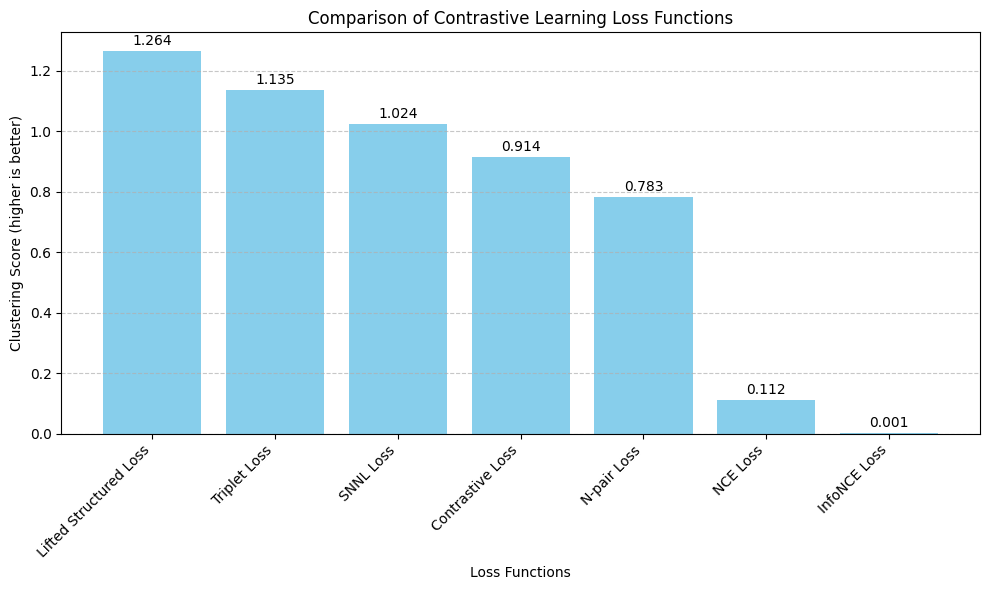

In [26]:
# First run the comparison
results = compare_loss_functions()

# Then generate and display the plot
plot = plot_loss_comparison(results)
plot.show()